# 迁移学习微调训练图像分类模型

在自己的图像分类数据集上，使用ImageNet预训练图像分类模型初始化，改动分类层，迁移学习微调训练

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置matplotlib中文字体

In [1]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [3]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font",family='SimHei') # 中文字体
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

--2023-03-26 17:19:25--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf”

/environment/minico 100%[===================>]   9.58M  18.8MB/s    用时 0.5s    

2023-03-26 17:19:26 (18.8 MB/s) - 已保存 “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf” [10050868/10050868])



## 导入工具包

In [4]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

## 获取计算硬件

In [5]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 图像预处理

In [6]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入图像分类数据集

In [7]:
# 数据集文件夹路径
dataset_dir = 'fruit30_split'

In [8]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 fruit30_split/train
测试集路径 fruit30_split/val


In [9]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [10]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 4375
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


In [11]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 1078
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


## 类别和索引号 一一对应

In [12]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [13]:
class_names

['哈密瓜',
 '圣女果',
 '山竹',
 '杨梅',
 '柚子',
 '柠檬',
 '桂圆',
 '梨',
 '椰子',
 '榴莲',
 '火龙果',
 '猕猴桃',
 '石榴',
 '砂糖橘',
 '胡萝卜',
 '脐橙',
 '芒果',
 '苦瓜',
 '苹果-红',
 '苹果-青',
 '草莓',
 '荔枝',
 '菠萝',
 '葡萄-白',
 '葡萄-红',
 '西瓜',
 '西红柿',
 '车厘子',
 '香蕉',
 '黄瓜']

In [14]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'哈密瓜': 0,
 '圣女果': 1,
 '山竹': 2,
 '杨梅': 3,
 '柚子': 4,
 '柠檬': 5,
 '桂圆': 6,
 '梨': 7,
 '椰子': 8,
 '榴莲': 9,
 '火龙果': 10,
 '猕猴桃': 11,
 '石榴': 12,
 '砂糖橘': 13,
 '胡萝卜': 14,
 '脐橙': 15,
 '芒果': 16,
 '苦瓜': 17,
 '苹果-红': 18,
 '苹果-青': 19,
 '草莓': 20,
 '荔枝': 21,
 '菠萝': 22,
 '葡萄-白': 23,
 '葡萄-红': 24,
 '西瓜': 25,
 '西红柿': 26,
 '车厘子': 27,
 '香蕉': 28,
 '黄瓜': 29}

In [15]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [16]:
idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

In [17]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

## 定义数据加载器DataLoader

In [77]:
from torch.utils.data import DataLoader

In [78]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

## 查看一个batch的图像和标注

In [79]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [80]:
images.shape

torch.Size([32, 3, 224, 224])

In [81]:
labels

tensor([11, 19,  3, 25, 29, 13, 21, 18, 11,  1, 13, 15, 13,  0, 15, 25,  0,  7,
        11, 10,  9,  6, 26,  2, 11, 10, 29, 29, 15,  8, 19,  8])

## 可视化一个batch的图像和标注

In [82]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [83]:
images[5].shape

(3, 224, 224)

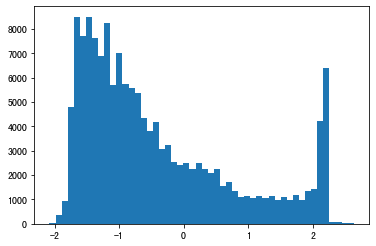

In [84]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:3')

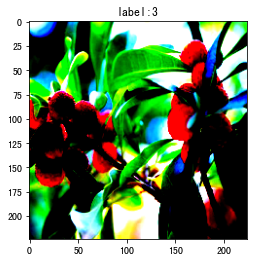

In [85]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [86]:
label = labels[idx].item()

In [87]:
label

3

In [88]:
pred_classname = idx_to_labels[label]

In [89]:
pred_classname

'杨梅'

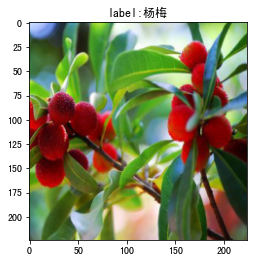

In [90]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

## 导入训练需使用的工具包

In [91]:
from torchvision import models
import torch.optim as optim

## 选择迁移学习训练方式

斯坦福CS231N【迁移学习】中文精讲：https://www.bilibili.com/video/BV1K7411W7So

斯坦福CS231N【迁移学习】官方笔记：https://cs231n.github.io/transfer-learning

ResNet算法精讲与论文逐句精读：https://www.bilibili.com/video/BV1vb4y1k7BV

### 选择一：只微调训练模型最后一层（全连接分类层）

In [92]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

In [93]:
model.fc

Linear(in_features=512, out_features=30, bias=True)

In [94]:
# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())

### 选择二：微调训练所有层

In [37]:
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择三：随机初始化模型全部权重，从头训练所有层

In [38]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

## 训练配置

In [95]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 20

## 模拟一个batch的训练

In [96]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [97]:
# 输入模型，执行前向预测
outputs = model(images)

In [98]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 30])

In [99]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [100]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [101]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

In [102]:
preds

tensor([13, 25, 10, 25, 23, 25, 19, 25, 26,  0, 19,  3, 25, 10,  5, 13, 13, 23,
        10,  5, 23,  3, 10,  3, 23,  3,  0, 10,  5, 13, 10, 25],
       device='cuda:0')

In [103]:
labels

tensor([ 3, 29, 13,  0,  6,  9, 20, 26, 10,  1, 22, 23,  4, 28, 13, 16,  6, 17,
        17, 13, 11, 12,  4, 23,  9, 25, 13,  9, 22, 11,  4, 11],
       device='cuda:0')

## 运行完整训练

In [74]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获取训练集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)           # 前向预测，获得当前 batch 的预测结果
        loss = criterion(outputs, labels) # 比较预测结果和标注，计算当前 batch 的交叉熵损失函数
        
        optimizer.zero_grad()
        loss.backward()                   # 损失函数对神经网络权重反向传播求梯度
        optimizer.step()                  # 优化更新神经网络权重

100%|██████████| 20/20 [02:52<00:00,  8.63s/it]


## 在测试集上初步测试

In [75]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader): # 获取测试集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)              # 前向预测，获得当前 batch 的预测置信度
        _, preds = torch.max(outputs, 1)     # 获得最大置信度对应的类别，作为预测结果
        total += labels.size(0)
        correct += (preds == labels).sum()   # 预测正确样本个数

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 34/34 [00:03<00:00, 11.28it/s]

测试集上的准确率为 87.013 %


## 保存模型

In [76]:
torch.save(model, 'checkpoint/fruit30_pytorch_C1.pth')

## 参考文档

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://www.bilibili.com/video/BV1qe4y1D7zD

https://www.bilibili.com/video/BV14J411X7Bb

https://www.bilibili.com/video/BV1w4411u7ay